<a href="https://colab.research.google.com/github/GuillermoBastian/LatamProject/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --------- Predicción de demora en vuelos - LATAM --------------

# Las respuestas las podrán encontrar en la última parte de este notebook "Conclusiones"

# 1. Importar Librerías

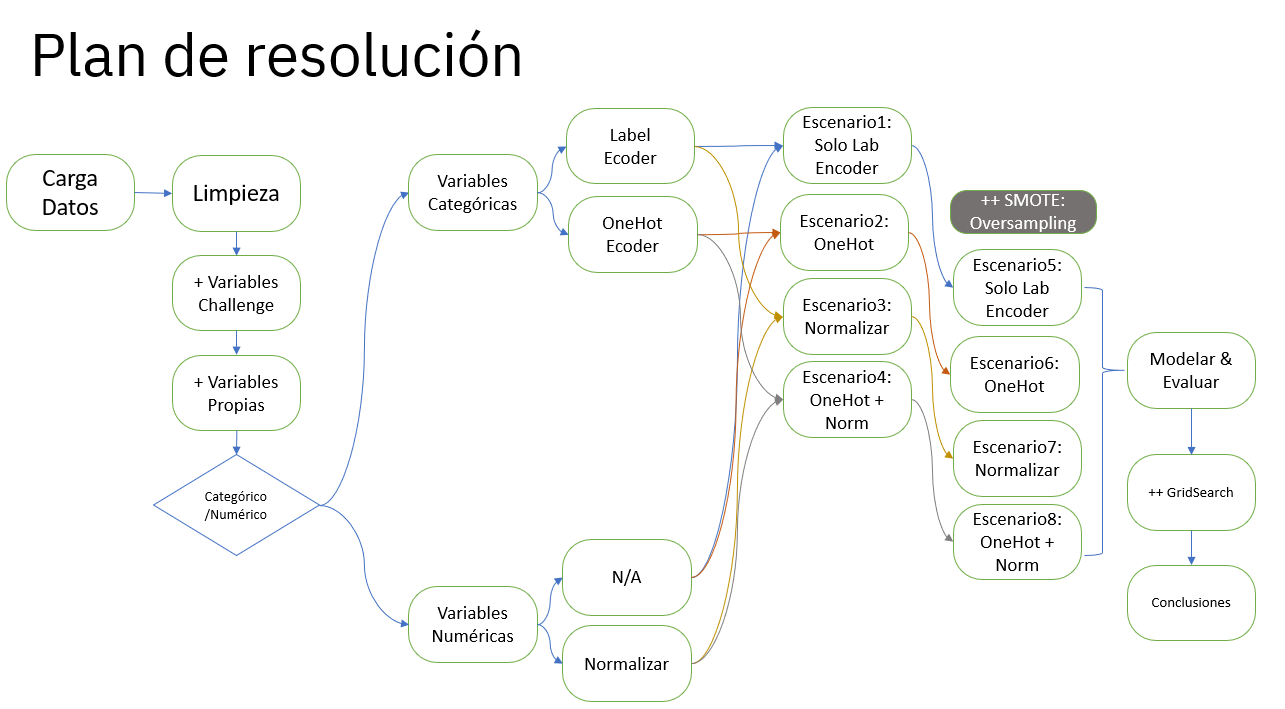

In [ ]:
# Librería carga datos
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Librerías procesamiento datos y evaluación
import pandas as pd 
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
# Librerías gráficos
import seaborn as sns

In [ ]:
#Librerías Modelamiento
import lightgbm as lgbm
import joblib # save model

# 2 Lectura & Añadir Campos Challenge

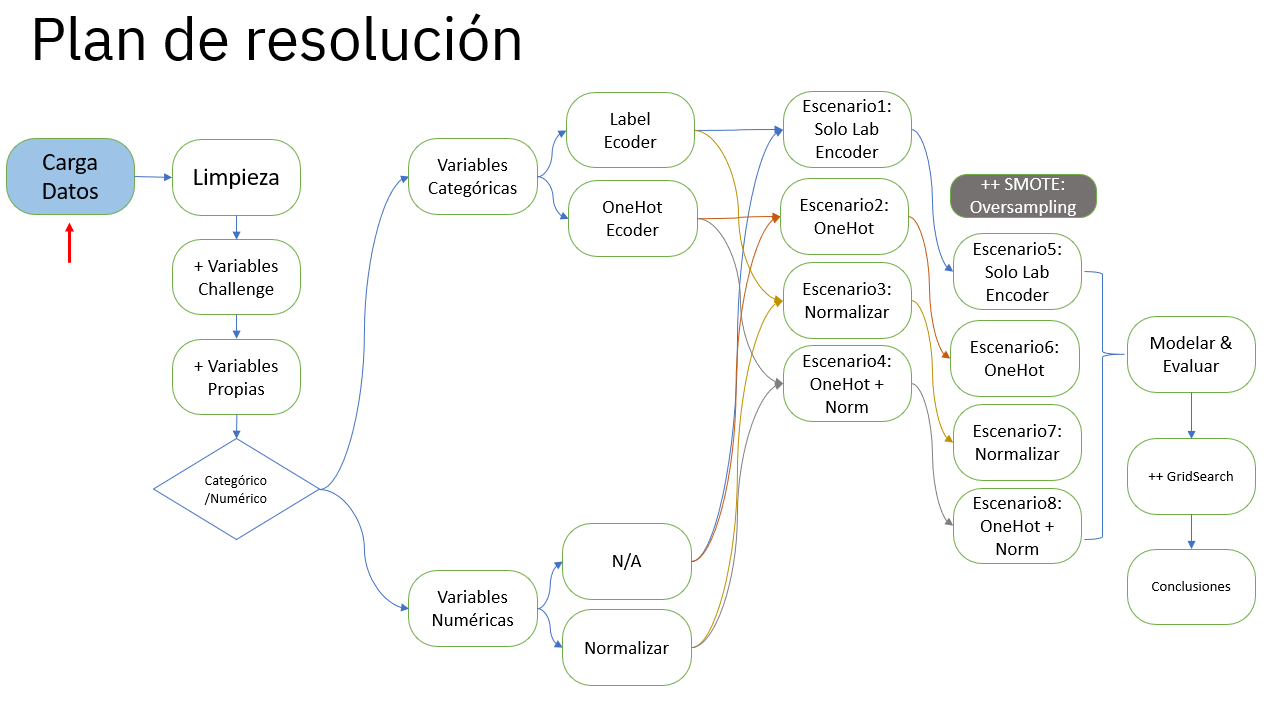

## 2.1 Load data

In [ ]:
original_df = pd.read_csv('gdrive/My Drive/LATAM/dataset_SCL.csv', parse_dates=['Fecha-I', 'Fecha-O'])
feriados_chile = pd.read_excel("/content/gdrive/MyDrive/LATAM/Feriados_Chile.xlsx")
km_tpo = pd.read_excel("/content/gdrive/MyDrive/LATAM/KM_DISTANCIA.xlsx")
original_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Fecha-I Vlo-I Ori-I Des-I Emp-I             Fecha-O Vlo-O Ori-O  \
0 2017-01-01 23:30:00   226  SCEL  KMIA   AAL 2017-01-01 23:33:00   226  SCEL   
1 2017-01-02 23:30:00   226  SCEL  KMIA   AAL 2017-01-02 23:39:00   226  SCEL   
2 2017-01-03 23:30:00   226  SCEL  KMIA   AAL 2017-01-03 23:39:00   226  SCEL   
3 2017-01-04 23:30:00   226  SCEL  KMIA   AAL 2017-01-04 23:33:00   226  SCEL   
4 2017-01-05 23:30:00   226  SCEL  KMIA   AAL 2017-01-05 23:28:00   226  SCEL   

  Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO              OPERA  \
0  KMIA   AAL    1    1  2017    Domingo         I  American Airlines   
1  KMIA   AAL    2    1  2017      Lunes         I  American Airlines   
2  KMIA   AAL    3    1  2017     Martes         I  American Airlines   
3  KMIA   AAL    4    1  2017  Miercoles         I  American Airlines   
4  KMIA   AAL    5    1  2017     Jueves         I  American Airlines   

   SIGLAORI SIGLADES  
0  Santiago    Miami  
1  Santiago    Miami  
2  Santiago    Miami  
3  Santiago    Miami  
4  Santiago    Miami

## 2.2 Borrar Variables que no agregan valor

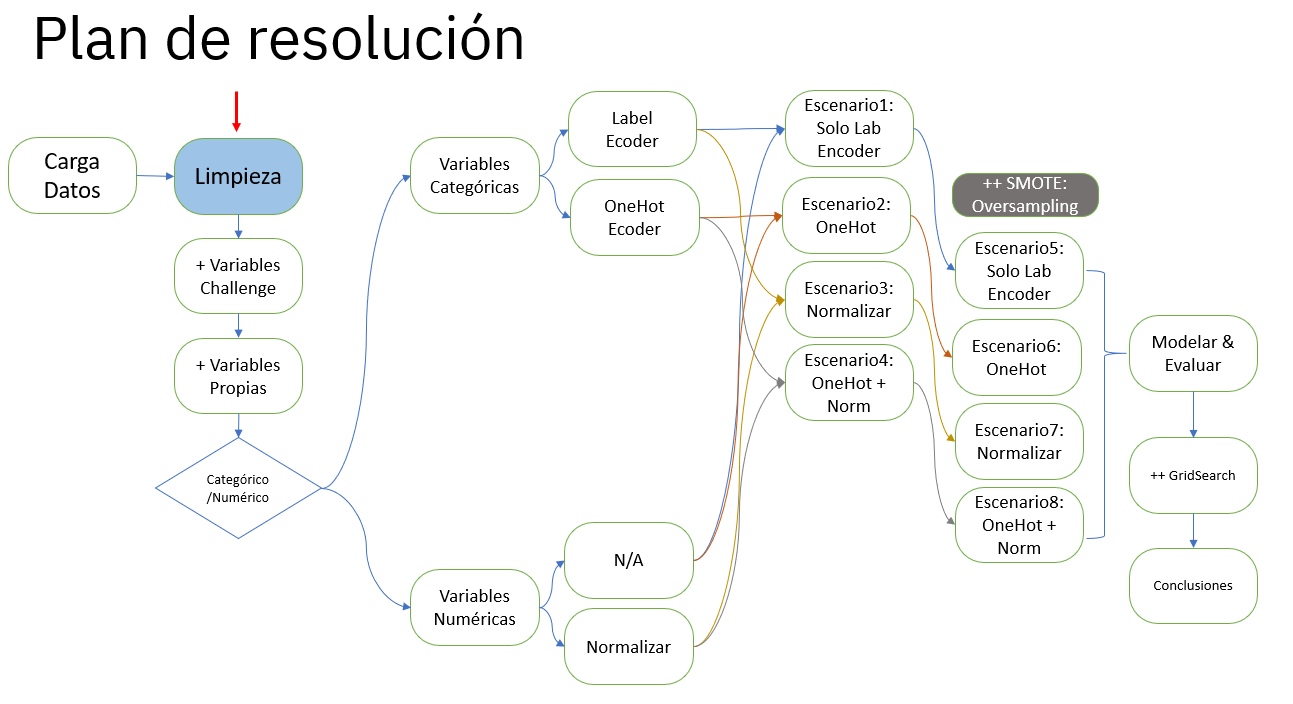

In [ ]:

cols_borrar = ["AÑO", "Ori-O", "Ori-I", "SIGLAORI"]

def delete_cols(df, cols_borrar):
  try:
    for k in cols_borrar:
      del df[k]
    print("OK: Columnas fueron borradas")
  except:
    print("ERROR: Columnas ya habían sido borradas")
    pass  

delete_cols(original_df, cols_borrar)

OK: Columnas fueron borradas


In [ ]:
original_df.head(3)

Fecha-I Vlo-I Des-I Emp-I             Fecha-O Vlo-O Des-O Emp-O  \
0 2017-01-01 23:30:00   226  KMIA   AAL 2017-01-01 23:33:00   226  KMIA   AAL   
1 2017-01-02 23:30:00   226  KMIA   AAL 2017-01-02 23:39:00   226  KMIA   AAL   
2 2017-01-03 23:30:00   226  KMIA   AAL 2017-01-03 23:39:00   226  KMIA   AAL   

   DIA  MES   DIANOM TIPOVUELO              OPERA SIGLADES  
0    1    1  Domingo         I  American Airlines    Miami  
1    2    1    Lunes         I  American Airlines    Miami  
2    3    1   Martes         I  American Airlines    Miami

## 2.4 Depurar missings!

In [ ]:
original_df.isna().sum() > 0

Fecha-I      False
Vlo-I        False
Des-I        False
Emp-I        False
Fecha-O      False
Vlo-O         True
Des-O        False
Emp-O        False
DIA          False
MES          False
DIANOM       False
TIPOVUELO    False
OPERA        False
SIGLADES     False
dtype: bool

In [ ]:
#Solo faltaba un dato del Nro. de vuelo, lo completaremos con el mismo código de Santiago a Lima con LAW para día jueves
original_df["Vlo-O"] = original_df["Vlo-O"].fillna(704)

## 2.3 Agregar Variables challenge

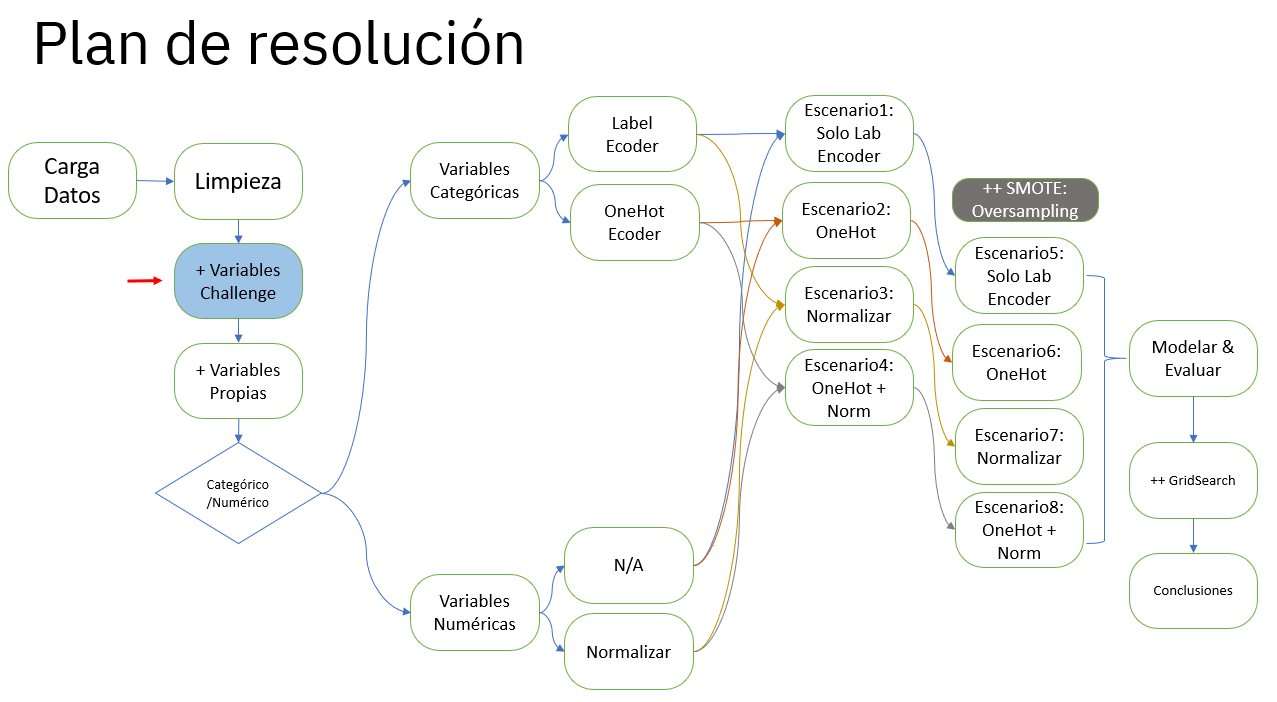

In [ ]:
#1.- Calcular temporada_alta  -- si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
original_df["temporada_alta"] = 0
original_df.loc[(original_df['Fecha-I'].dt.strftime('%m-%d') >= '12-15') | (original_df['Fecha-I'].dt.strftime('%m-%d') <= '03-03'), "temporada_alta"] = 1
original_df.loc[(original_df['Fecha-I'].dt.strftime('%m-%d') >= '07-15') & (original_df['Fecha-I'].dt.strftime('%m-%d') <= '07-31'), "temporada_alta"] = 1
original_df.loc[(original_df['Fecha-I'].dt.strftime('%m-%d') >= '09-11') & (original_df['Fecha-I'].dt.strftime('%m-%d') <= '09-30'), "temporada_alta"] = 1

#2.- Calcular dif_min 
original_df["dif_min"] = (original_df["Fecha-O"] - original_df["Fecha-I"])
original_df["dif_min"]  = original_df["dif_min"]/np.timedelta64(1,'m')

# 3.- Calcular atraso_15 
original_df["atraso_15"] = 0
original_df.loc[original_df["dif_min"] > 15, "atraso_15"] = 1

#4.- Calcular periodo_dia : mañana : 0 | tarde : 1 | noche : 2
original_df["periodo_dia"] = 0
original_df.loc[(original_df['Fecha-I'].dt.strftime('%H:%M') >= '05:00') & (original_df['Fecha-I'].dt.strftime('%H:%M') <= '11:59'), "periodo_dia"] = 0
original_df.loc[(original_df['Fecha-I'].dt.strftime('%H:%M') >= '12:00') & (original_df['Fecha-I'].dt.strftime('%H:%M') <= '18:59'), "periodo_dia"] = 1
original_df.loc[(original_df['Fecha-I'].dt.strftime('%H:%M') >= '19:00') | (original_df['Fecha-I'].dt.strftime('%H:%M') <= '04:59'), "periodo_dia"] = 2


original_df.to_csv("synthetic_features.csv")

In [ ]:
cols_borrar = ["dif_min"]
delete_cols(original_df, cols_borrar)

OK: Columnas fueron borradas


In [ ]:
original_df.head(3)

Fecha-I Vlo-I Des-I Emp-I             Fecha-O Vlo-O Des-O Emp-O  \
0 2017-01-01 23:30:00   226  KMIA   AAL 2017-01-01 23:33:00   226  KMIA   AAL   
1 2017-01-02 23:30:00   226  KMIA   AAL 2017-01-02 23:39:00   226  KMIA   AAL   
2 2017-01-03 23:30:00   226  KMIA   AAL 2017-01-03 23:39:00   226  KMIA   AAL   

   DIA  MES   DIANOM TIPOVUELO              OPERA SIGLADES  temporada_alta  \
0    1    1  Domingo         I  American Airlines    Miami               1   
1    2    1    Lunes         I  American Airlines    Miami               1   
2    3    1   Martes         I  American Airlines    Miami               1   

   atraso_15  periodo_dia  
0          0            2  
1          0            2  
2          0            2

## 2.4 Añadir Variables propias

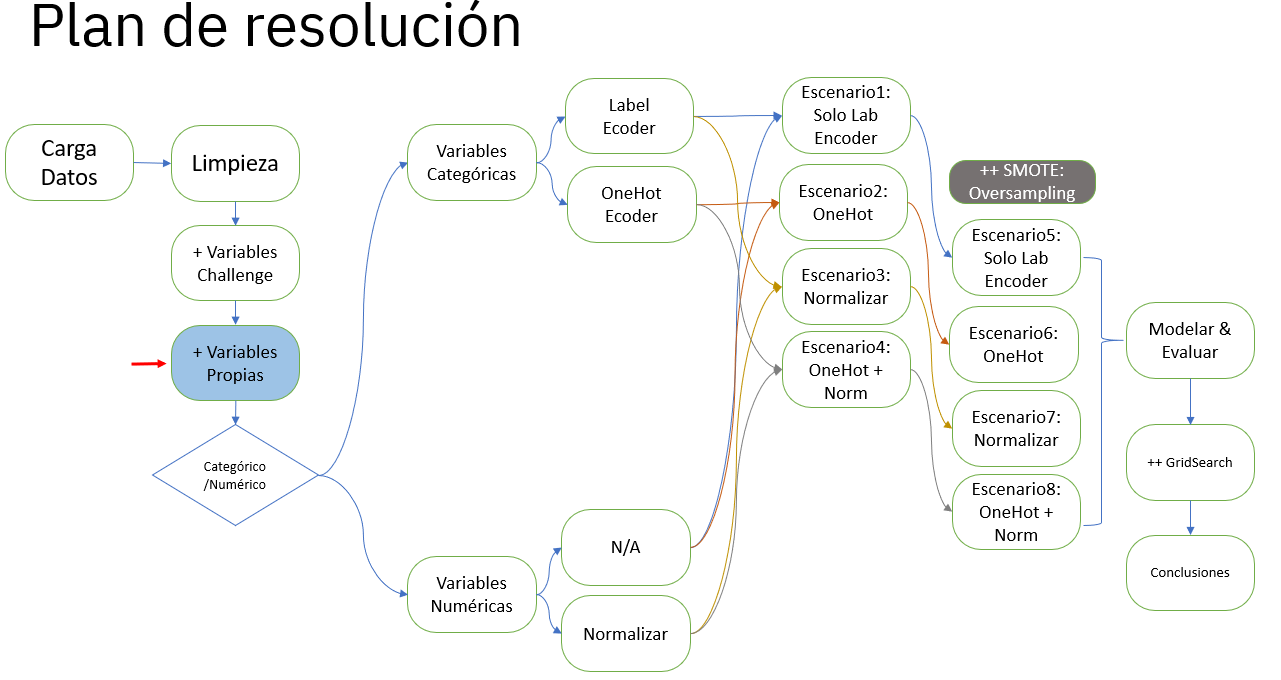

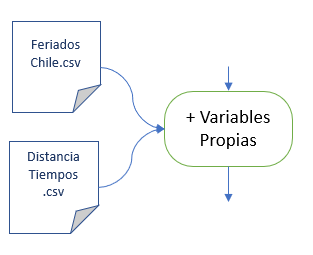

In [ ]:
feriados_chile.head(3)

Evento  Mes   Dia
0      ano_nuevo  1.0   1.0
1  viernes_santo  4.0  14.0
2   sabado_santo  4.0  15.0

### ***Variables a crear:***
* Feriados
* Hora de Partida
* Emp - Vuelo
* Km y Tiempo de vuelo de SCL hacia destino
* Flag de último día de mes. 1 si es último día del mes

In [ ]:
# 1.- Feriados:
main_nfields_df = pd.merge(original_df, feriados_chile,  how='left', left_on=['DIA','MES'], right_on = ['Dia','Mes'])
cols_borrar = ['Dia','Mes']
delete_cols(main_nfields_df, cols_borrar)
main_nfields_df['Evento'] = main_nfields_df['Evento'].fillna(0)

# 2.- Hora de partida
main_nfields_df["HORA"] = main_nfields_df["Fecha-I"].dt.hour + main_nfields_df["Fecha-I"].dt.minute/60

# 3.- Emp - Vuelo
main_nfields_df["Emp-Vlo"] = main_nfields_df["Emp-I"].astype(str) + main_nfields_df["Vlo-I"].astype(str)
main_nfields_df.head()

# 3.- Km diferencia + 4.- Tiempo de vuelo
main_nfields_df = pd.merge(main_nfields_df, km_tpo,  how='left', left_on=['SIGLADES'], right_on = ['SIGLADES'])
cols_borrar = ['Duración_hrs']
delete_cols(main_nfields_df, cols_borrar)
main_nfields_df

# 6.- último dia del mes

def calc_ult_dia (anio):
  lista_ult_dia = []
  lista_mes = []
  for i in range(1,13): 
    dummy_date = "{}-01-{}".format(str(i),str(anio))
    lista_mes.append(i)
    lista_ult_dia.append(pd.Period(dummy_date,freq='M').end_time.date().day)
    df_ult_dia = pd.DataFrame(list(zip(lista_mes, lista_ult_dia)),
               columns =['MES', 'ULT_DIA'])
  return df_ult_dia 

df_ult_dia = calc_ult_dia(2017)

main_nfields_df = pd.merge(main_nfields_df, df_ult_dia,  how='left', left_on=['MES'], right_on = ['MES'])
main_nfields_df.head()


OK: Columnas fueron borradas
OK: Columnas fueron borradas


Fecha-I Vlo-I Des-I Emp-I             Fecha-O Vlo-O Des-O Emp-O  \
0 2017-01-01 23:30:00   226  KMIA   AAL 2017-01-01 23:33:00   226  KMIA   AAL   
1 2017-01-02 23:30:00   226  KMIA   AAL 2017-01-02 23:39:00   226  KMIA   AAL   
2 2017-01-03 23:30:00   226  KMIA   AAL 2017-01-03 23:39:00   226  KMIA   AAL   
3 2017-01-04 23:30:00   226  KMIA   AAL 2017-01-04 23:33:00   226  KMIA   AAL   
4 2017-01-05 23:30:00   226  KMIA   AAL 2017-01-05 23:28:00   226  KMIA   AAL   

   DIA  MES  ... temporada_alta atraso_15 periodo_dia dif_min     Evento  \
0    1    1  ...              1         0           2     3.0  ano_nuevo   
1    2    1  ...              1         0           2     9.0          0   
2    3    1  ...              1         0           2     9.0          0   
3    4    1  ...              1         0           2     3.0          0   
4    5    1  ...              1         0           2    -2.0          0   

   HORA  Emp-Vlo    KM DURACION_MIN  ULT_DIA  
0  23.5   AAL226  6627        497.0       31  
1  23.5   AAL226  6627        497.0       31  
2  23.5   AAL226  6627        497.0       31  
3  23.5   AAL226  6627        497.0       31  
4  23.5   AAL226  6627        497.0       31  

[5 rows x 24 columns]

In [ ]:
main_nfields_df.columns

Index(['Fecha-I', 'Vlo-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O', 'Des-O',
       'Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES',
       'temporada_alta', 'atraso_15', 'periodo_dia', 'Evento', 'HORA',
       'Emp-Vlo', 'KM', 'DURACION_MIN', 'ULT_DIA'],
      dtype='object')

In [ ]:
#Borrar últiomas columnas 
cols_borrar = ["Fecha-I", "Fecha-O", "Vlo-O", "Emp-O"]
delete_cols(main_nfields_df, cols_borrar)

OK: Columnas fueron borradas


# 3 Análisis de datos

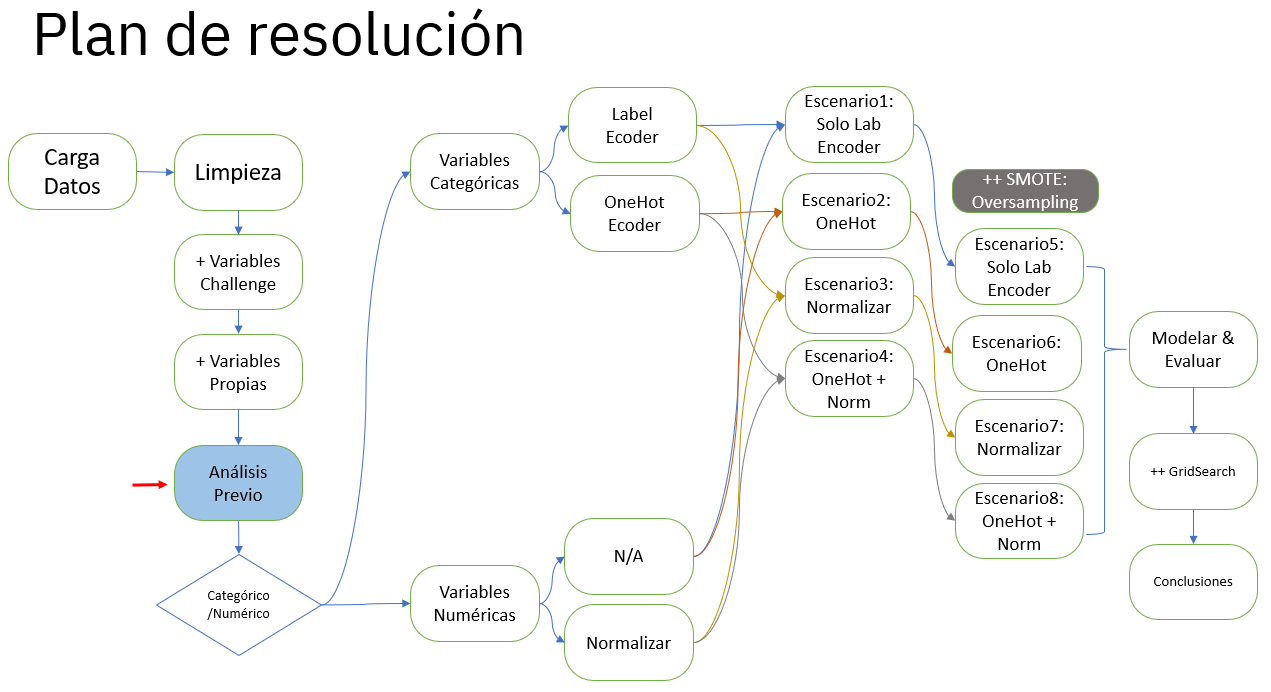

In [ ]:
#Reconocer si la columna es categorica o numérica
def reconocer_cate_num(df, total_cols):
  numerical_columns = []
  categorical_columns = []

  for i in total_cols:
    if df[i].dtype == object:
      categorical_columns.append(i)
    else:
      numerical_columns.append(i)
  return categorical_columns, numerical_columns

total_cols = main_nfields_df.columns
categorical_columns, numerical_columns = reconocer_cate_num(main_nfields_df, total_cols)

main_nfields_df[categorical_columns] = main_nfields_df[categorical_columns].astype(str)

In [ ]:
analysis_df = main_nfields_df

In [ ]:
# Label Encoder
# from sklearn.preprocessing import OrdinalEncoder
# oe = OrdinalEncoder()
# categorical_df = oe.fit_transform(analysis_df[categorical_columns])
# analysis_df[categorical_columns] = categorical_df

In [ ]:
# Reconocer variables independientes del target
ycols = ["atraso_15"]

def get_complement_columns(total_cols, excluded_cols):
  xcols= []
  for i in total_cols:
    if i not in ycols:
      xcols.append(i)
  return xcols

xcols = get_complement_columns(total_cols, ycols)

In [ ]:
analysis_df.describe()

DIA           MES  temporada_alta     atraso_15   periodo_dia  \
count  68206.000000  68206.000000    68206.000000  68206.000000  68206.000000   
mean      15.714790      6.622585        0.333724      0.184940      0.882650   
std        8.782886      3.523321        0.471546      0.388252      0.782485   
min        1.000000      1.000000        0.000000      0.000000      0.000000   
25%        8.000000      3.000000        0.000000      0.000000      0.000000   
50%       16.000000      7.000000        0.000000      0.000000      1.000000   
75%       23.000000     10.000000        1.000000      0.000000      2.000000   
max       31.000000     12.000000        1.000000      1.000000      2.000000   

            dif_min          HORA            KM  DURACION_MIN       ULT_DIA  
count  68206.000000  68206.000000  68206.000000  68206.000000  68206.000000  
mean       9.110855     12.899395   2179.883940    181.264757     30.437381  
std       19.313387      5.805976   2341.414645    163.920700      0.857487  
min      -14.000000      0.000000    301.000000     43.000000     28.000000  
25%       -1.000000      8.000000    916.000000     94.000000     30.000000  
50%        4.000000     13.000000   1221.000000    116.000000     31.000000  
75%       12.000000     17.766667   2453.000000    203.000000     31.000000  
max      161.000000     23.983333  11903.000000    894.000000     31.000000

In [ ]:
#analysis_df[xcols].corr()["dif_min"]

#Resultados - VARIABLES:
# MES
# TIPOVUELO
# Vlo-I / Vlo-O
# SIGLADES

In [ ]:
analysis_df

Vlo-I Des-I Emp-I Des-O  DIA  MES     DIANOM TIPOVUELO  \
0       226  KMIA   AAL  KMIA    1    1    Domingo         I   
1       226  KMIA   AAL  KMIA    2    1      Lunes         I   
2       226  KMIA   AAL  KMIA    3    1     Martes         I   
3       226  KMIA   AAL  KMIA    4    1  Miercoles         I   
4       226  KMIA   AAL  KMIA    5    1     Jueves         I   
...     ...   ...   ...   ...  ...  ...        ...       ...   
68201   400  SPJC   JAT  SPJC   22   12    Viernes         I   
68202   400  SPJC   JAT  SPJC   25   12      Lunes         I   
68203   400  SPJC   JAT  SPJC   27   12  Miercoles         I   
68204   400  SPJC   JAT  SPJC   29   12    Viernes         I   
68205   400  SPJC   JAT  SPJC   31   12    Domingo         I   

                   OPERA SIGLADES  temporada_alta  atraso_15  periodo_dia  \
0      American Airlines    Miami               1          0            2   
1      American Airlines    Miami               1          0            2   
2      American Airlines    Miami               1          0            2   
3      American Airlines    Miami               1          0            2   
4      American Airlines    Miami               1          0            2   
...                  ...      ...             ...        ...          ...   
68201       JetSmart SPA     Lima               1          1            1   
68202       JetSmart SPA     Lima               1          1            1   
68203       JetSmart SPA     Lima               1          1            1   
68204       JetSmart SPA     Lima               1          0            1   
68205       JetSmart SPA     Lima               1          0            1   

          Evento       HORA Emp-Vlo    KM  DURACION_MIN  ULT_DIA  
0      ano_nuevo  23.500000  AAL226  6627         497.0       31  
1              0  23.500000  AAL226  6627         497.0       31  
2              0  23.500000  AAL226  6627         497.0       31  
3              0  23.500000  AAL226  6627         497.0       31  
4              0  23.500000  AAL226  6627         497.0       31  
...          ...        ...     ...   ...           ...      ...  
68201          0  14.916667  JAT400  2453         203.0       31  
68202    navidad  14.916667  JAT400  2453         203.0       31  
68203          0  14.916667  JAT400  2453         203.0       31  
68204          0  14.916667  JAT400  2453         203.0       31  
68205          0  14.916667  JAT400  2453         203.0       31  

[68206 rows x 19 columns]

In [ ]:
# flights = main_nfields_df.pivot("MES", "Vlo-I" , "dif_min")
# ax = sns.heatmap(flights)

In [ ]:
print(len(main_nfields_df.columns))
print(len(categorical_columns))
print(len(numerical_columns))

19
10
9


# 5. Pre-Procesamiento:  
5.1 One Hot - Variables Categoricas <br>
5.2 Normalizacion - Variables Numéricas <br>

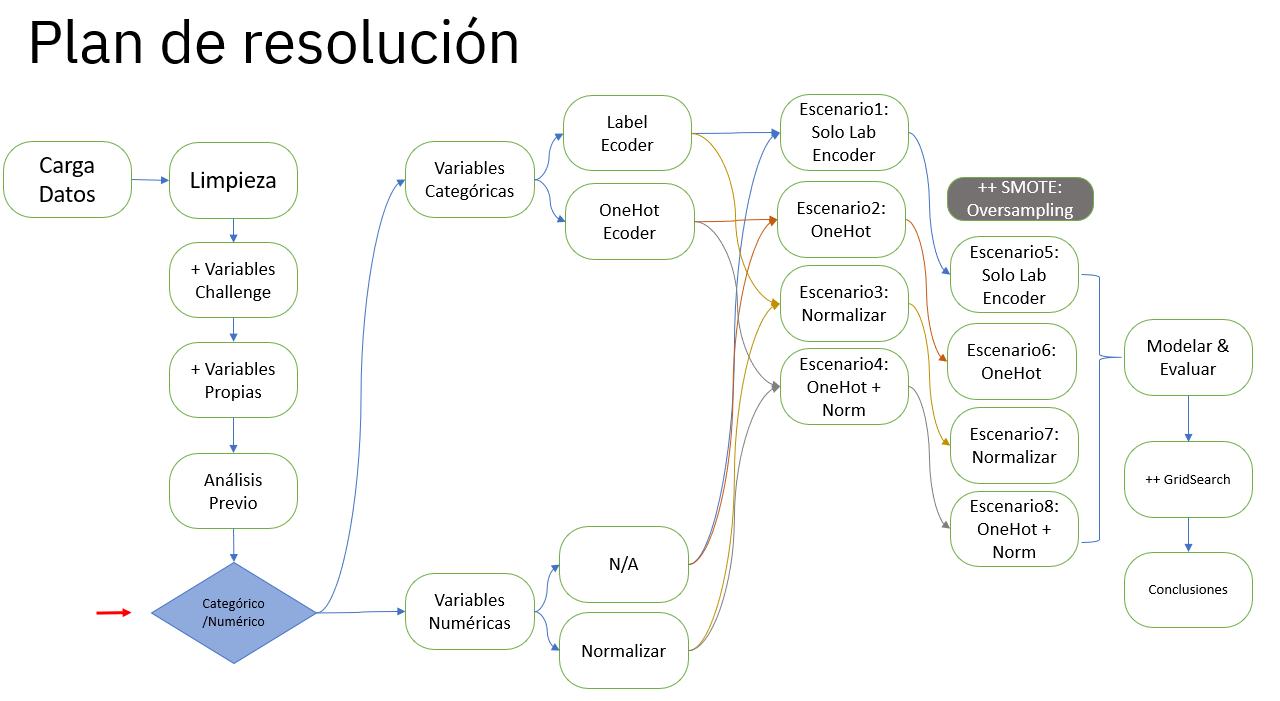

# 5.0 Label Encoding

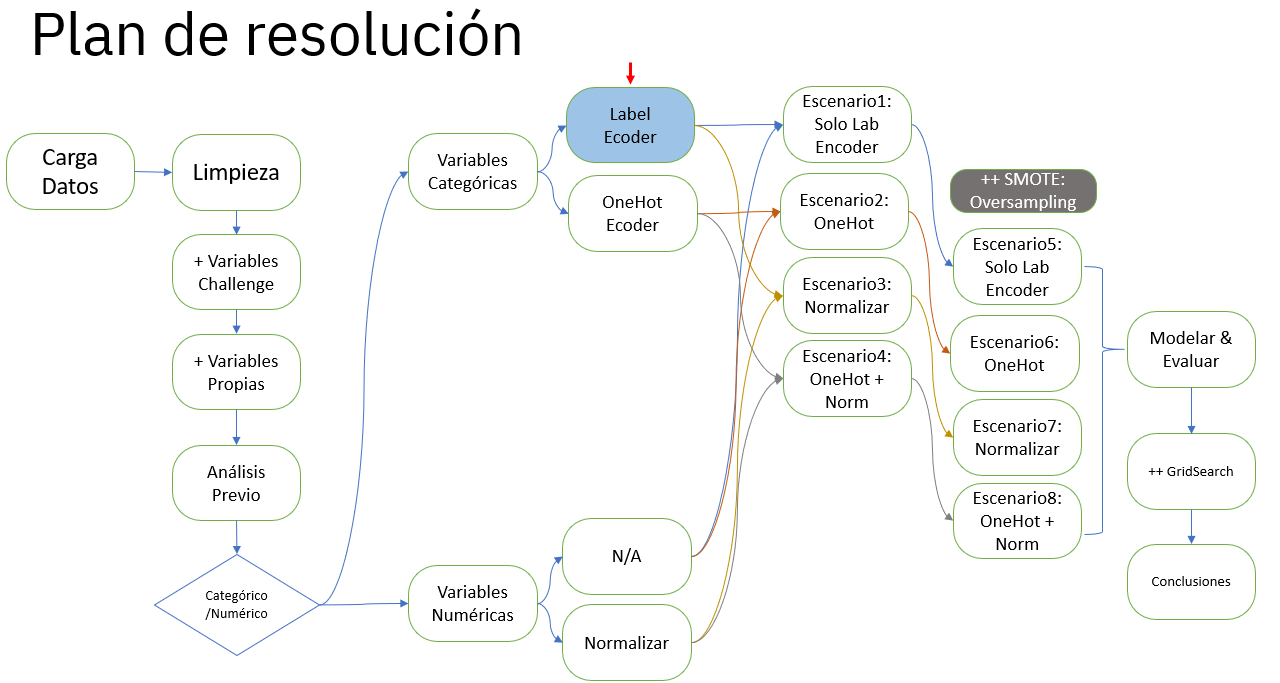

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
le_data = main_nfields_df[categorical_columns]
le_df = main_nfields_df[categorical_columns]

le_df = main_nfields_df[categorical_columns]
oe = OrdinalEncoder()

In [ ]:
le_df[categorical_columns] = oe.fit_transform(le_data)
le_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Vlo-I  Des-I  Emp-I  Des-O  DIANOM  TIPOVUELO  OPERA  SIGLADES  Evento  \
0  219.0    9.0    0.0   10.0     0.0        0.0    5.0      34.0     1.0   
1  219.0    9.0    0.0   10.0     2.0        0.0    5.0      34.0     0.0   
2  219.0    9.0    0.0   10.0     3.0        0.0    5.0      34.0     0.0   
3  219.0    9.0    0.0   10.0     4.0        0.0    5.0      34.0     0.0   
4  219.0    9.0    0.0   10.0     1.0        0.0    5.0      34.0     0.0   

   Emp-Vlo  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0

## 5.1 One - Hot: Categoricas

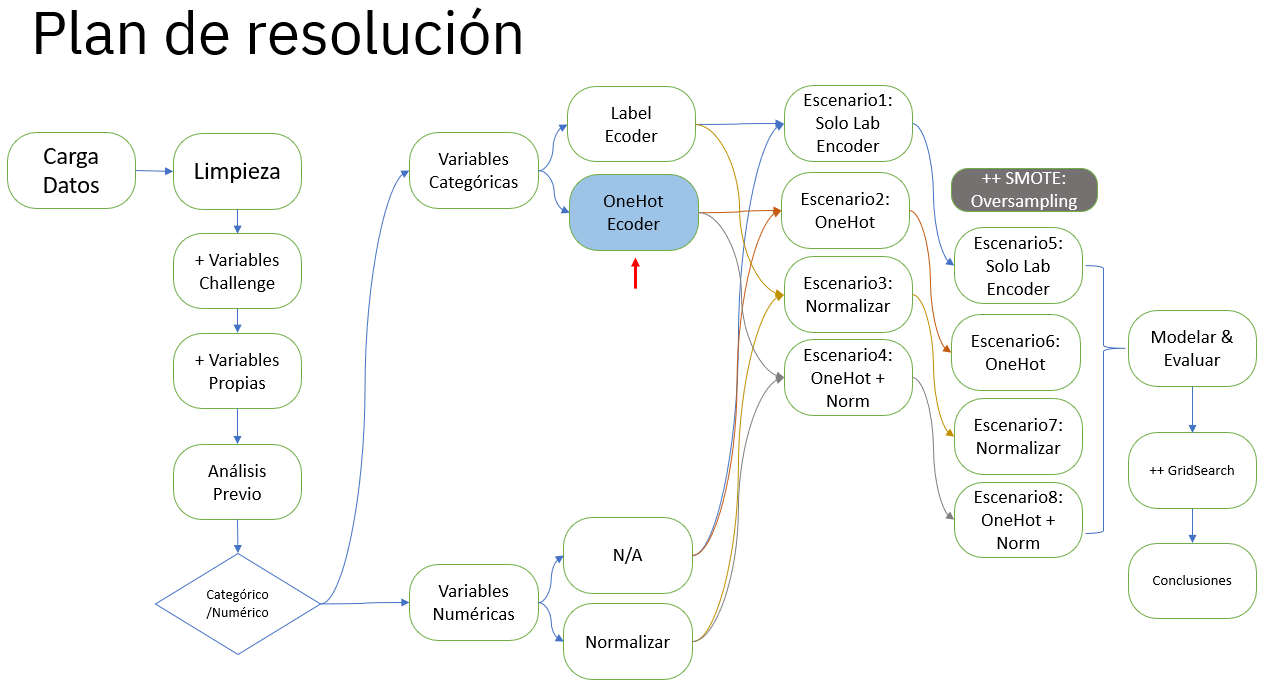

In [ ]:
one_hot_status= 'N'

In [ ]:

if one_hot_status == 'N':
  for i in categorical_columns:
    main_onehot_df = pd.get_dummies(main_nfields_df[i], prefix=i)
    one_hot_status= 'Y'


main_onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 68205
Columns: 685 entries, Emp-Vlo_AAL226 to Emp-Vlo_UAL846A
dtypes: uint8(685)
memory usage: 45.1 MB


# 5.2 Normalizar variables numéricas

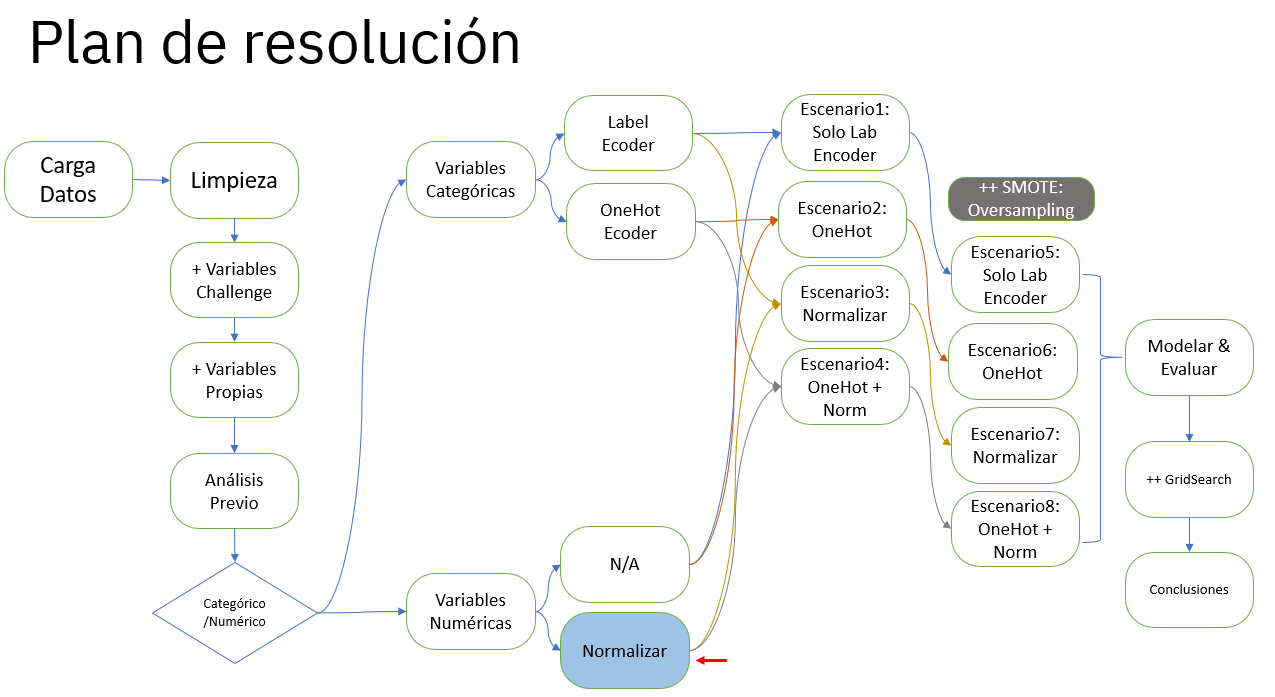

In [ ]:
def normalizar_df(df):
  scaler = StandardScaler()
  scaler.fit(df)
  scaled = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled, columns=df.columns)
  return scaled_df

In [ ]:
norm_df = normalizar_df(main_nfields_df[numerical_columns])*100
norm_df.head()

DIA         MES  temporada_alta  atraso_15  periodo_dia        HORA  \
0 -167.540592 -159.583128      141.297041 -47.634352   142.796198  182.582277   
1 -156.154728 -159.583128      141.297041 -47.634352   142.796198  182.582277   
2 -144.768865 -159.583128      141.297041 -47.634352   142.796198  182.582277   
3 -133.383002 -159.583128      141.297041 -47.634352   142.796198  182.582277   
4 -121.997139 -159.583128      141.297041 -47.634352   142.796198  182.582277   

           KM  DURACION_MIN    ULT_DIA  
0  189.934264    192.616038  65.613028  
1  189.934264    192.616038  65.613028  
2  189.934264    192.616038  65.613028  
3  189.934264    192.616038  65.613028  
4  189.934264    192.616038  65.613028

# 6. Train - Test Split

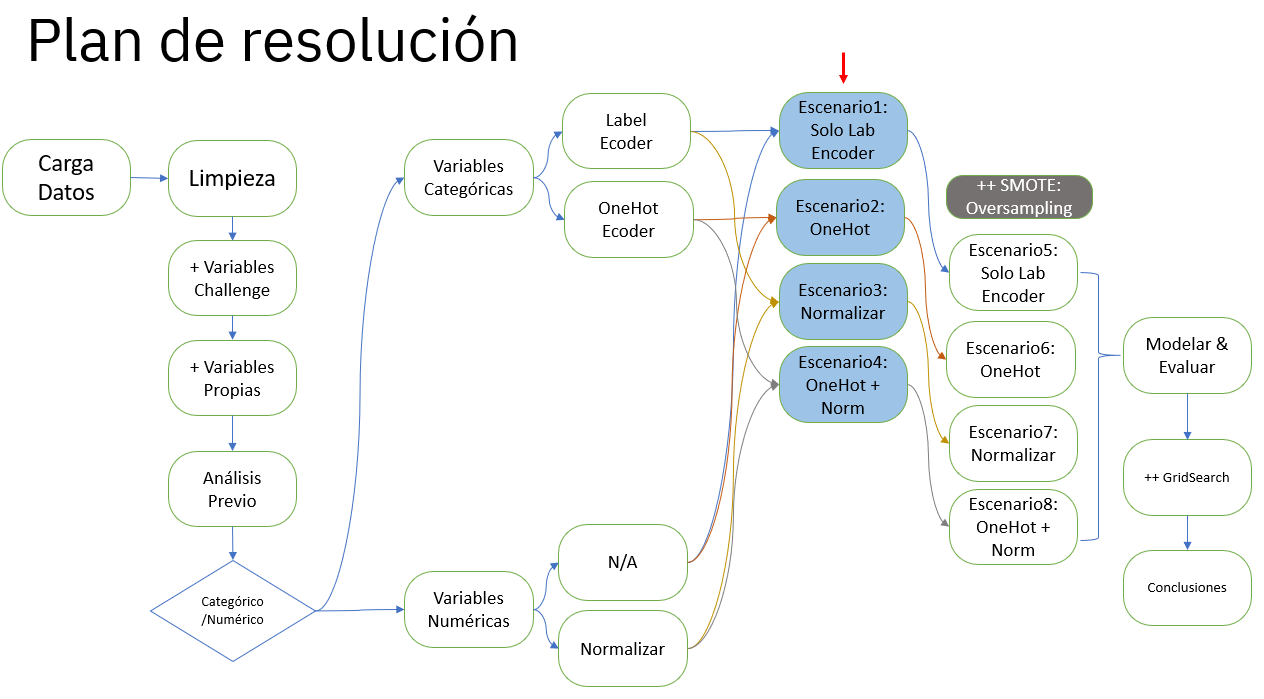

## 6.1 Get input scenarios


In [ ]:
input_model = pd.concat([le_df , main_nfields_df[numerical_columns]], axis=1) #Escenario 1: Normal - Label encoder + variables numéricas
input_model_onehot = pd.concat([main_onehot_df, main_nfields_df[numerical_columns]], axis=1) #Escenario 2: onehot - OneHot + variables numéricas
input_model_norm = pd.concat([le_df[categorical_columns], norm_df] , axis=1) #Escenario 3: Normalizadas - Label encoder + Numerico_Normalizado
input_model_onehot_norm = pd.concat([main_onehot_df, norm_df] , axis=1) #Escenario 4: All - Onehot - Label Numerico_Normalizado 


input_model_onehot["atraso_15"] = input_model["atraso_15"]
input_model_norm["atraso_15"] = input_model["atraso_15"]
input_model_onehot_norm["atraso_15"] = input_model["atraso_15"]

## 6.2 Get X and Y

In [ ]:
# Reconocer variables independientes del target
ycols = ["atraso_15", "dif_min"]
y_cols_clasiff = ["atraso_15"]

xcols_input = get_complement_columns(input_model.columns, ycols)
xcols_onehot = get_complement_columns(input_model_onehot.columns, ycols)
xcols_norm = get_complement_columns(input_model_norm.columns, ycols)
xcols_onehot_norm = get_complement_columns(input_model_onehot_norm.columns, ycols)


## 6.1. Oversampling

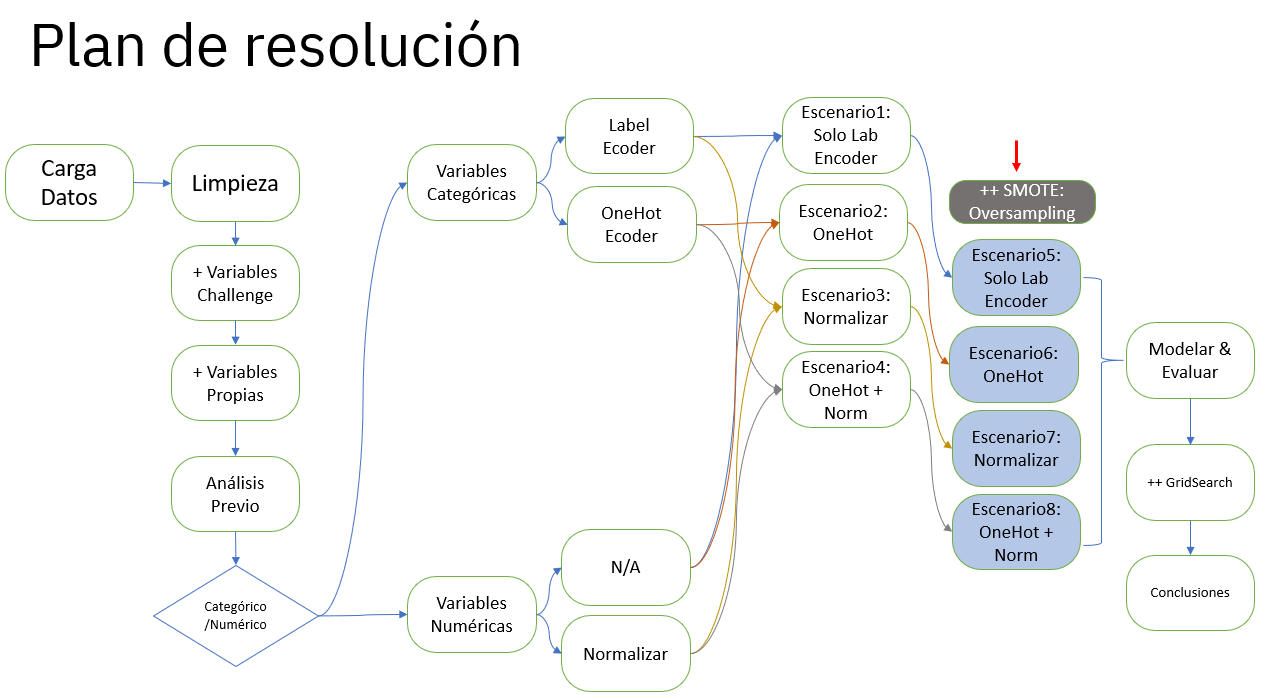

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE 
import imblearn
from numpy import where
from matplotlib import pyplot

In [ ]:
input_model.shape[0]

68206

In [ ]:
input_model["atraso_15"].sum()
#0: 55592
#1: 12614
#total : 68206

12614

In [ ]:
oversample = SMOTE() #MODIFICAR
X_sm, y_sm = oversample.fit_resample(input_model[xcols_input], input_model[y_cols_clasiff]) #Normal Escenario (label_ancoder) + SMOTE
X_1h_sm, y_1h_sm = oversample.fit_resample(input_model_onehot[xcols_onehot], input_model_onehot[y_cols_clasiff]) #1hot + SMOTE
X_nor_sm, y_nor_sm = oversample.fit_resample(input_model_norm[xcols_norm], input_model_norm[y_cols_clasiff]) #norm + SMOTE
X_all_sm, y_all_sm = oversample.fit_resample(input_model_onehot_norm[xcols_onehot_norm], input_model_onehot_norm[y_cols_clasiff]) # 1hot + norm + SMOTE

In [ ]:
#Consolidado
X_y_sm = pd.concat([X_sm, y_sm], axis=1)
X_y_1h_sm = pd.concat([X_1h_sm, y_1h_sm], axis=1)
X_y_nor_sm = pd.concat([X_nor_sm, y_nor_sm], axis=1)
X_y_all_sm = pd.concat([X_all_sm, y_all_sm], axis=1)

In [ ]:
#Cols de X
xcols_norm_sm = get_complement_columns(X_y_sm.columns, ycols)
xcols_norm_sm = get_complement_columns(X_y_1h_sm.columns, ycols)
xcols_norm_sm = get_complement_columns(X_y_nor_sm.columns, ycols)
xcols_norm_sm = get_complement_columns(X_y_all_sm.columns, ycols)


## 6.2 Train - Test Split

### A.- SIN SMOTE <br>
Escenarios
  * Escenario 1: Normal- Solo Label Encoder
  * Escenario 2: 1 hot- Categoricas con one hot
  * Escenario 3: Normalizado- Numéricas Normalizadas
  * Escenario 4: All- CAtegoricas one hot + numéricas normalizadas

In [ ]:
ts = 0.15 #test size
strtfy_by = ["atraso_15", "MES", "TIPOVUELO"] 

#SIN SMOTE
X_train, X_test, y_train, y_test = train_test_split(input_model[xcols_input], input_model[y_cols_clasiff], test_size=ts, random_state=42, stratify = input_model[strtfy_by], shuffle=True)
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(input_model_onehot[xcols_onehot], input_model_onehot[y_cols_clasiff], test_size=ts, random_state=42, stratify = input_model_onehot[y_cols_clasiff], shuffle=True)
X_train_nor, X_test_nor, y_train_nor, y_test_nor = train_test_split(input_model_norm[xcols_norm], input_model_norm[y_cols_clasiff], test_size=ts, random_state=42, stratify = input_model_norm[y_cols_clasiff], shuffle=True)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(input_model_onehot_norm[xcols_onehot_norm], input_model_onehot_norm[y_cols_clasiff], test_size=ts, random_state=42, stratify = input_model_onehot_norm[y_cols_clasiff], shuffle=True)

In [ ]:
#LightGBM scale_pos_weight para datos SIN SMOTE
a,b = y_train.value_counts(normalize = True).tolist()  
oversampling_rate = a/b
oversampling_rate

4.406658739595719

### B.- CON SMOTE <br>
Escenarios
  * Escenario 5: Normal- Solo Label Encoder
  * Escenario 6: 1 hot- Categoricas con one hot
  * Escenario 7: Normalizado- Numéricas Normalizadas
  * Escenario 8: All- CAtegoricas one hot + numéricas normalizadas



In [ ]:
#CON SMOTE
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=ts, random_state=42, stratify = X_y_sm["atraso_15"], shuffle=True)
X_train_1hsm, X_test_1hsm, y_train_1hsm, y_test_1hsm = train_test_split(X_1h_sm, y_1h_sm, test_size=ts, random_state=42, stratify = X_y_1h_sm["atraso_15"], shuffle=True)
X_train_norsm, X_test_norsm, y_train_norsm, y_test_norsm = train_test_split(X_nor_sm, y_nor_sm , test_size=ts, random_state=42, stratify = X_y_nor_sm["atraso_15"], shuffle=True)
X_train_allsm, X_test_allsm, y_train_allsm, y_test_allsm = train_test_split(X_all_sm, y_all_sm, test_size=ts, random_state=42, stratify = X_y_all_sm["atraso_15"], shuffle=True)

# 7. Modeling

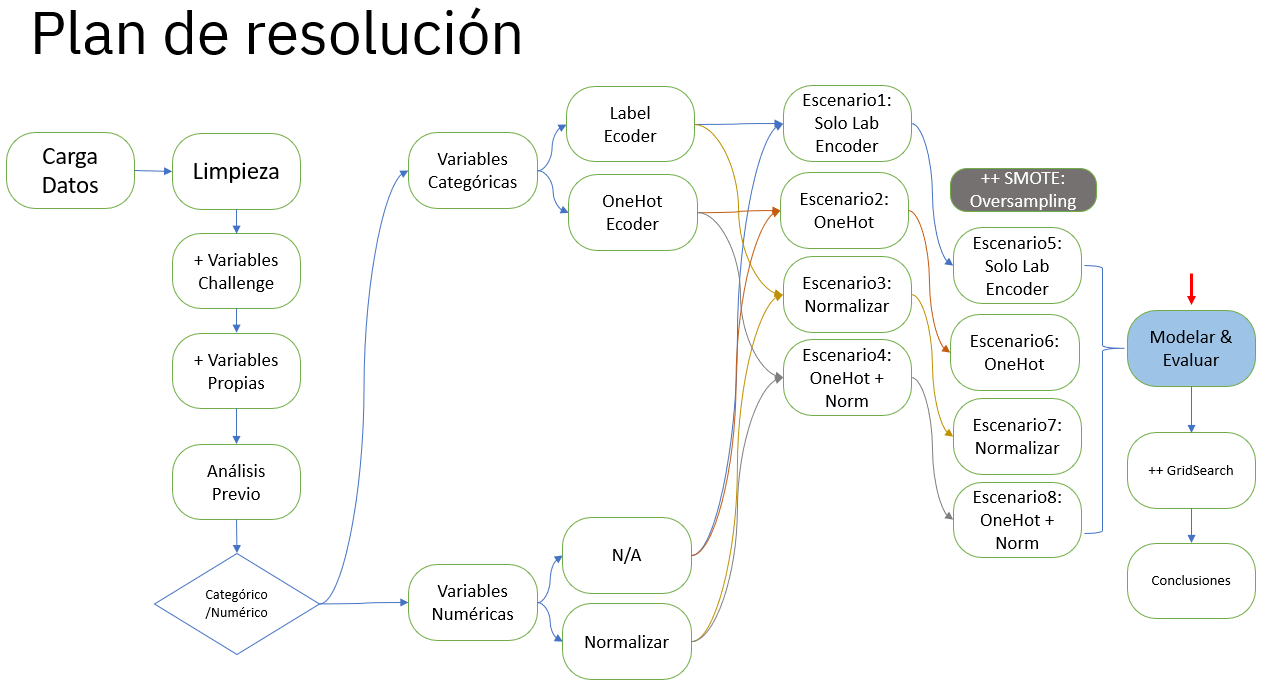

## 7.1 Modeling w/o SMOTE

### Escenario 1: Normal- Solo Label Encoder



In [ ]:
opt_depth = 10
opt_leaves = 2**opt_depth
 

clf = lgbm.LGBMClassifier(n_estimators=5000, scale_pos_weight = 6,  num_leaves=opt_leaves, max_depth = opt_depth, learning_rate=0.01, first_metric_only = True)
#boosting_type='gbdt', learning_rate=0.1, n_estimators=5000,
#                          n_jobs=-1, random_state=42, scale_pos_weight = 5, num_leaves=opt_leaves, max_depth = opt_depth
clf.fit(X_train, y_train, eval_set= [(X_test, y_test)], eval_metric = 'auc', early_stopping_rounds=100)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.691793	valid_0's binary_logloss: 0.477198
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.694405	valid_0's binary_logloss: 0.475854
[3]	valid_0's auc: 0.697625	valid_0's binary_logloss: 0.474641
[4]	valid_0's auc: 0.698132	valid_0's binary_logloss: 0.473564
[5]	valid_0's auc: 0.698361	valid_0's binary_logloss: 0.472595
[6]	valid_0's auc: 0.698703	valid_0's binary_logloss: 0.47175
[7]	valid_0's auc: 0.699663	valid_0's binary_logloss: 0.471
[8]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.470349
[9]	valid_0's auc: 0.700606	valid_0's binary_logloss: 0.469755
[10]	valid_0's auc: 0.701834	valid_0's binary_logloss: 0.469308
[11]	valid_0's auc: 0.702532	valid_0's binary_logloss: 0.468871
[12]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.46857
[13]	valid_0's auc: 0.703903	valid_0's binary_logloss: 0.468304
[14]	valid_0's auc: 0.704393	valid_0's binary_logloss: 0.468113
[15]	valid_0's auc: 0.705207	valid_0's binary_logloss: 0

LGBMClassifier(first_metric_only=True, learning_rate=0.01, max_depth=10,
               n_estimators=5000, num_leaves=1024, scale_pos_weight=6)

In [ ]:
clf_best = clf.best_iteration_

### Escenario 2: 1hot- Categoricas con one hot

In [ ]:
clf_oh = lgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, importance_type='split', learning_rate=0.005, n_estimators=5000,
                          n_jobs=-1, num_leaves=31, random_state=42, scale_pos_weight = 4.5, first_metric_only = True, )
clf_oh.fit(X_train_oh, y_train_oh, eval_metric = 'auc', early_stopping_rounds=100, eval_set= [(X_test_oh, y_test_oh)])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.642529	valid_0's binary_logloss: 0.478467
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.642383	valid_0's binary_logloss: 0.478152
[3]	valid_0's auc: 0.642285	valid_0's binary_logloss: 0.477875
[4]	valid_0's auc: 0.641665	valid_0's binary_logloss: 0.477617
[5]	valid_0's auc: 0.641794	valid_0's binary_logloss: 0.477373
[6]	valid_0's auc: 0.642711	valid_0's binary_logloss: 0.477158
[7]	valid_0's auc: 0.644371	valid_0's binary_logloss: 0.476943
[8]	valid_0's auc: 0.644236	valid_0's binary_logloss: 0.476765
[9]	valid_0's auc: 0.645092	valid_0's binary_logloss: 0.476601
[10]	valid_0's auc: 0.648088	valid_0's binary_logloss: 0.476416
[11]	valid_0's auc: 0.64845	valid_0's binary_logloss: 0.476265
[12]	valid_0's auc: 0.651093	valid_0's binary_logloss: 0.47611
[13]	valid_0's auc: 0.652019	valid_0's binary_logloss: 0.475994
[14]	valid_0's auc: 0.652952	valid_0's binary_logloss: 0.47592
[15]	valid_0's auc: 0.653866	valid_0's binary_logloss

LGBMClassifier(first_metric_only=True, learning_rate=0.005, n_estimators=5000,
               random_state=42, scale_pos_weight=4.5)

### Escenario 3: Normalizado- Numéricas Normalizadas

### Escenario 4: All- CAtegoricas one hot + numéricas normalizadas

In [ ]:
opt_depth = 12
opt_leaves = 2**opt_depth
 

clf_oh_nor = lgbm.LGBMClassifier(boosting_type='gbdt', learning_rate=0.015, n_estimators=5000,
                          n_jobs=-1, random_state=42, scale_pos_weight = 5, num_leaves=opt_leaves, max_depth = opt_depth)
clf_oh_nor.fit(X_train_all, y_train_oh, eval_set= [(X_test_all, y_test_oh)], eval_metric = 'auc')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.47702	valid_0's auc: 0.674334
[2]	valid_0's binary_logloss: 0.475385	valid_0's auc: 0.685804
[3]	valid_0's binary_logloss: 0.473976	valid_0's auc: 0.688563
[4]	valid_0's binary_logloss: 0.47283	valid_0's auc: 0.689713
[5]	valid_0's binary_logloss: 0.471786	valid_0's auc: 0.696683
[6]	valid_0's binary_logloss: 0.470851	valid_0's auc: 0.700307
[7]	valid_0's binary_logloss: 0.470144	valid_0's auc: 0.701285
[8]	valid_0's binary_logloss: 0.469652	valid_0's auc: 0.701484
[9]	valid_0's binary_logloss: 0.469354	valid_0's auc: 0.703365
[10]	valid_0's binary_logloss: 0.469038	valid_0's auc: 0.704096
[11]	valid_0's binary_logloss: 0.468814	valid_0's auc: 0.704725
[12]	valid_0's binary_logloss: 0.468703	valid_0's auc: 0.706403
[13]	valid_0's binary_logloss: 0.468756	valid_0's auc: 0.707009
[14]	valid_0's binary_logloss: 0.468869	valid_0's auc: 0.707663
[15]	valid_0's binary_logloss: 0.469082	valid_0's auc: 0.707952
[16]	valid_0's binary_logloss: 0.469294	valid_0's a

KeyboardInterrupt: ignored

### Escenario 5: Normal + SM

In [ ]:
opt_depth = 7
opt_leaves = 2**opt_depth
 

clf_sm = lgbm.LGBMClassifier(boosting_type='gbdt', learning_rate=0.015, n_estimators=5000,
                           n_jobs=-1, random_state=42, scale_pos_weight = 1, num_leaves=opt_leaves, max_depth = opt_depth, first_metric_only = True)
clf_sm.fit(X_train_sm, y_train_sm, eval_set= [(X_test_sm, y_test_sm)], eval_metric = 'auc')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.760556	valid_0's binary_logloss: 0.690655
[2]	valid_0's auc: 0.760558	valid_0's binary_logloss: 0.688212
[3]	valid_0's auc: 0.760832	valid_0's binary_logloss: 0.685814
[4]	valid_0's auc: 0.761012	valid_0's binary_logloss: 0.683462
[5]	valid_0's auc: 0.760934	valid_0's binary_logloss: 0.68116
[6]	valid_0's auc: 0.761147	valid_0's binary_logloss: 0.678891
[7]	valid_0's auc: 0.761228	valid_0's binary_logloss: 0.676671
[8]	valid_0's auc: 0.761254	valid_0's binary_logloss: 0.674489
[9]	valid_0's auc: 0.761323	valid_0's binary_logloss: 0.672355
[10]	valid_0's auc: 0.761577	valid_0's binary_logloss: 0.670244
[11]	valid_0's auc: 0.761467	valid_0's binary_logloss: 0.66819
[12]	valid_0's auc: 0.761401	valid_0's binary_logloss: 0.666166
[13]	valid_0's auc: 0.761576	valid_0's binary_logloss: 0.664174
[14]	valid_0's auc: 0.761592	valid_0's binary_logloss: 0.662229
[15]	valid_0's auc: 0.761794	valid_0's binary_logloss: 0.660307
[16]	valid_0's auc: 0.761943	valid_0's binary_loglo

LGBMClassifier(first_metric_only=True, learning_rate=0.01, max_depth=7,
               n_estimators=5000, num_leaves=128, random_state=42,
               scale_pos_weight=1)

In [ ]:
y_pred_train_sm = clf_sm.predict(X_train_sm,  num_iteration=clf_sm.best_iteration_)
y_pred_sm = clf_sm.predict(X_test_sm,  num_iteration=clf_sm.best_iteration_)

print('LightGBM Escenario 5 Model f1_train score: {0:0.4f}'.format(f1_score(y_train_sm, y_pred_train_sm)))
print('LightGBM Escenario 5 Model f1_test score: {0:0.4f}'.format(f1_score(y_test_sm, y_pred_sm)))
print('LightGBM Escenario 5 Model auc_train score: {0:0.4f}'.format(roc_auc_score(y_train_sm, y_pred_train_sm)))
print('LightGBM Escenario 5 Model auc_test score: {0:0.4f}'.format(roc_auc_score(y_test_sm, y_pred_sm)))

LightGBM Escenario 5 Model f1_train score: 0.9075
LightGBM Escenario 5 Model f1_test score: 0.8678
LightGBM Escenario 5 Model auc_train score: 0.9134
LightGBM Escenario 5 Model auc_test score: 0.8769


### Escenario 6: 1Hot + SMOTE

In [ ]:
opt_depth = 7
opt_leaves = 2**opt_depth
 

clf_1hsm = lgbm.LGBMClassifier(boosting_type='gbdt', learning_rate=0.015, n_estimators=5000,
                           n_jobs=-1, random_state=42, scale_pos_weight = 1, num_leaves=opt_leaves, max_depth = opt_depth, first_metric_only = True)
clf_1hsm.fit(X_train_1hsm, y_train_1hsm , eval_set= [(X_test_1hsm, y_test_1hsm)], eval_metric = 'auc')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.710627	valid_0's binary_logloss: 0.690923
[2]	valid_0's auc: 0.716231	valid_0's binary_logloss: 0.688753
[3]	valid_0's auc: 0.729798	valid_0's binary_logloss: 0.686404
[4]	valid_0's auc: 0.72905	valid_0's binary_logloss: 0.684334
[5]	valid_0's auc: 0.731699	valid_0's binary_logloss: 0.682109
[6]	valid_0's auc: 0.732474	valid_0's binary_logloss: 0.680136
[7]	valid_0's auc: 0.733052	valid_0's binary_logloss: 0.678049
[8]	valid_0's auc: 0.735014	valid_0's binary_logloss: 0.676002
[9]	valid_0's auc: 0.735492	valid_0's binary_logloss: 0.674221
[10]	valid_0's auc: 0.735969	valid_0's binary_logloss: 0.672287
[11]	valid_0's auc: 0.737239	valid_0's binary_logloss: 0.670606
[12]	valid_0's auc: 0.737998	valid_0's binary_logloss: 0.668797
[13]	valid_0's auc: 0.743797	valid_0's binary_logloss: 0.666738
[14]	valid_0's auc: 0.744084	valid_0's binary_logloss: 0.66495
[15]	valid_0's auc: 0.744606	valid_0's binary_logloss: 0.663273
[16]	valid_0's auc: 0.748383	valid_0's binary_loglo

LGBMClassifier(first_metric_only=True, learning_rate=0.015, max_depth=7,
               n_estimators=5000, num_leaves=128, random_state=42,
               scale_pos_weight=1)

In [ ]:
y_pred_train_1hsm = clf_1hsm.predict(X_train_1hsm,  num_iteration=clf_1hsm.best_iteration_)
y_pred_1hsm = clf_1hsm.predict(X_test_1hsm,  num_iteration=clf_1hsm.best_iteration_)

print('LightGBM Escenario 5 Model f1_train score: {0:0.4f}'.format(f1_score(y_train_1hsm, y_pred_train_1hsm)))
print('LightGBM Escenario 5 Model f1_test score: {0:0.4f}'.format(f1_score(y_test_1hsm, y_pred_1hsm)))
print('LightGBM Escenario 5 Model auc_train score: {0:0.4f}'.format(roc_auc_score(y_train_1hsm, y_pred_train_1hsm)))
print('LightGBM Escenario 5 Model auc_test score: {0:0.4f}'.format(roc_auc_score(y_test_1hsm, y_pred_1hsm)))

LightGBM Escenario 5 Model f1_train score: 0.8224
LightGBM Escenario 5 Model f1_test score: 0.8023
LightGBM Escenario 5 Model auc_train score: 0.8199
LightGBM Escenario 5 Model auc_test score: 0.7985


### Escenario 7: Norm + SMOTE **(BEST)**

In [ ]:
opt_depth = 8
opt_leaves = 2**opt_depth 

clf_nor_sm = lgbm.LGBMClassifier(boosting_type='gbdt', learning_rate=0.03, n_estimators=5000,
                          n_jobs=-1, random_state=42, scale_pos_weight = 1, num_leaves=opt_leaves, max_depth = opt_depth, first_metric_only = True)
clf_nor_sm.fit(X_train_norsm, y_train_norsm, eval_set= [(X_test_norsm, y_test_norsm)], eval_metric = 'auc', early_stopping_rounds=100)

y_pred_train_norsm = clf_nor_sm.predict(X_train_norsm,  num_iteration=clf_nor_sm.best_iteration_)
y_pred_norsm = clf_nor_sm.predict(X_test_norsm,  num_iteration=clf_nor_sm.best_iteration_)

print(i)
print('LightGBM Escenario 7 Model f1_train score: {0:0.4f}'.format(f1_score(y_train_norsm, y_pred_train_norsm)))
print('LightGBM Escenario 7 Model f1_test score: {0:0.4f}'.format(f1_score(y_test_norsm , y_pred_norsm)))
print('LightGBM Escenario 7 Model auc_train score: {0:0.4f}'.format(roc_auc_score(y_train_norsm, y_pred_train_norsm)))
print('LightGBM Escenario 7 Model auc_test score: {0:0.4f}'.format(roc_auc_score(y_test_norsm , y_pred_norsm)))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.807603	valid_0's binary_logloss: 0.682839
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.807855	valid_0's binary_logloss: 0.673119
[3]	valid_0's auc: 0.808058	valid_0's binary_logloss: 0.663966
[4]	valid_0's auc: 0.807908	valid_0's binary_logloss: 0.655321
[5]	valid_0's auc: 0.807983	valid_0's binary_logloss: 0.647153
[6]	valid_0's auc: 0.807943	valid_0's binary_logloss: 0.639439
[7]	valid_0's auc: 0.810385	valid_0's binary_logloss: 0.632067
[8]	valid_0's auc: 0.857508	valid_0's binary_logloss: 0.624629
[9]	valid_0's auc: 0.85736	valid_0's binary_logloss: 0.617786
[10]	valid_0's auc: 0.8604	valid_0's binary_logloss: 0.610902
[11]	valid_0's auc: 0.869248	valid_0's binary_logloss: 0.60612
[12]	valid_0's auc: 0.875311	valid_0's binary_logloss: 0.599091
[13]	valid_0's auc: 0.874392	valid_0's binary_logloss: 0.593049
[14]	valid_0's auc: 0.873752	valid_0's binary_logloss: 0.587289
[15]	valid_0's auc: 0.877424	valid_0's binary_logloss:

### Guardar Mejor Modelo

In [ ]:
joblib.dump(clf_nor_sm, 'lgbm_finalmodel.pkl')

['lgbm_finalmodel.pkl']

### Guardar Predict Proba

In [ ]:
y_pred_norsm_proba = clf_nor_sm.predict_proba(X_test_norsm,  num_iteration=clf_nor_sm.best_iteration_)
joblib.dump(y_pred_norsm_proba, 'predict_proba_results.pkl')

['predict_proba_results.pkl']

### Log de resultados modelo

In [ ]:
#LOG:

#LR: 0.015
# LightGBM Escenario 7 Model f1_train score: 0.8998
# LightGBM Escenario 7 Model f1_test score: 0.8790
# LightGBM Escenario 7 Model auc_train score: 0.9075
# LightGBM Escenario 7 Model auc_test score: 0.8883

#LR: 0.010
#LightGBM Escenario 7 Model f1_train score: 0.9010
#LightGBM Escenario 7 Model f1_test score: 0.8811
#LightGBM Escenario 7 Model auc_train score: 0.9084
#LightGBM Escenario 7 Model auc_test score: 0.8903

# LR: 0.025
# LightGBM Escenario 7 Model f1_train score: 0.9026
# LightGBM Escenario 7 Model f1_test score: 0.8809
# LightGBM Escenario 7 Model auc_train score: 0.9098
# LightGBM Escenario 7 Model auc_test score: 0.8900

# LR: 0.03
# LightGBM Escenario 7 Model f1_train score: 0.9049
# LightGBM Escenario 7 Model f1_test score: 0.8821
# LightGBM Escenario 7 Model auc_train score: 0.9118
# LightGBM Escenario 7 Model auc_test score: 0.8909

# LR: 0.03 and depth 8
# LightGBM Escenario 7 Model f1_train score: 0.9051
# LightGBM Escenario 7 Model f1_test score: 0.8829
# LightGBM Escenario 7 Model auc_train score: 0.9120
# LightGBM Escenario 7 Model auc_test score: 0.8917

# LR: 0.03 and depth 9
# LightGBM Escenario 7 Model f1_train score: 0.9121
# LightGBM Escenario 7 Model f1_test score: 0.8849
# LightGBM Escenario 7 Model auc_train score: 0.9180
# LightGBM Escenario 7 Model auc_test score: 0.8932

# LR: 0.03 and depth 10
# LightGBM Escenario 7 Model f1_train score: 0.9148
# LightGBM Escenario 7 Model f1_test score: 0.8860
# LightGBM Escenario 7 Model auc_train score: 0.9204
# LightGBM Escenario 7 Model auc_test score: 0.8941

### Feature Imrpotance

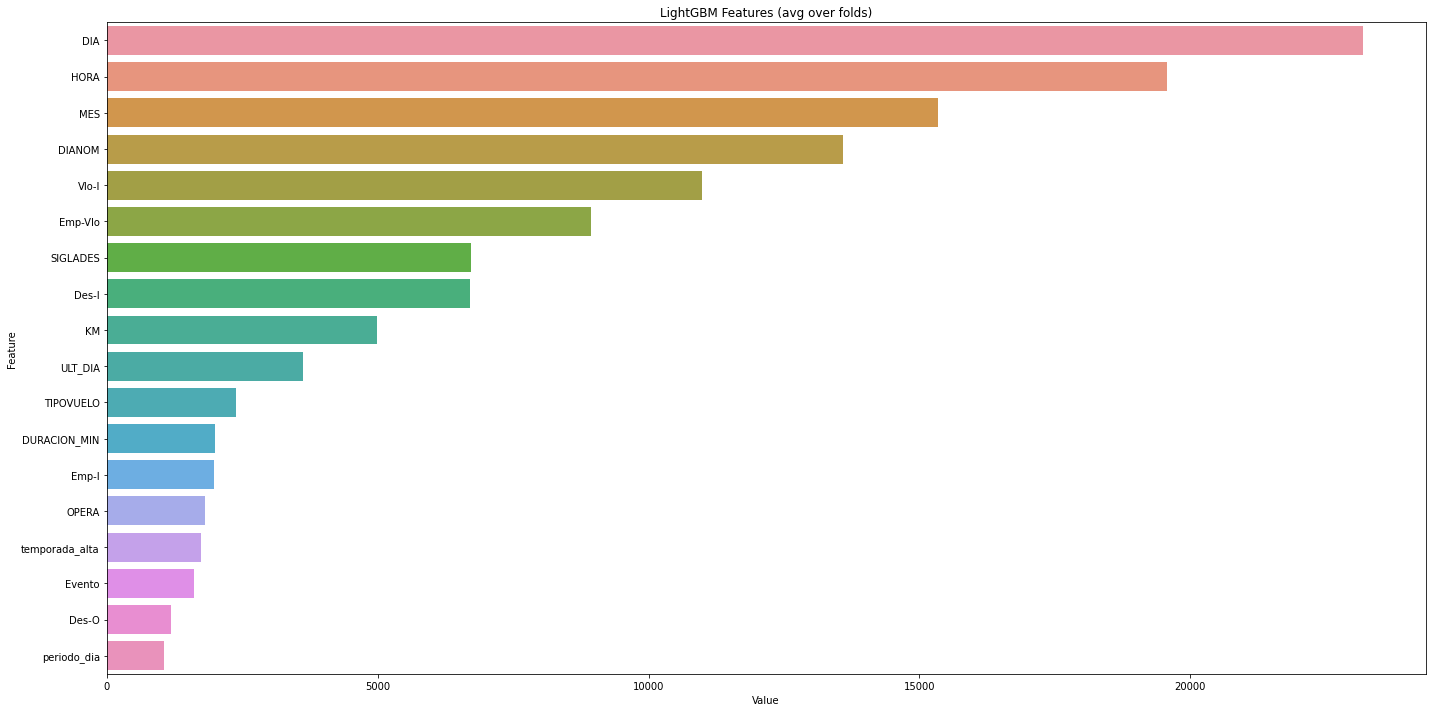

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


feature_imp = pd.DataFrame(sorted(zip(clf_nor_sm.feature_importances_, X_train_norsm.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')



### Escenario 8: 1Hot + Norm + SMOTE

In [ ]:
opt_depth = 7
opt_leaves = 2**opt_depth
 

clf_all_sm = lgbm.LGBMClassifier(boosting_type='gbdt', learning_rate=0.015, n_estimators=5000,
                           n_jobs=-1, random_state=42, scale_pos_weight = 1, num_leaves=opt_leaves, max_depth = opt_depth, first_metric_only = True)
clf_all_sm.fit(X_train_allsm , y_train_allsm , eval_set= [(X_test_allsm , y_test_allsm )], eval_metric = 'auc')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.713345	valid_0's binary_logloss: 0.690886
[2]	valid_0's auc: 0.713579	valid_0's binary_logloss: 0.688692
[3]	valid_0's auc: 0.714232	valid_0's binary_logloss: 0.68657
[4]	valid_0's auc: 0.715061	valid_0's binary_logloss: 0.684498
[5]	valid_0's auc: 0.739088	valid_0's binary_logloss: 0.681944
[6]	valid_0's auc: 0.759972	valid_0's binary_logloss: 0.679664
[7]	valid_0's auc: 0.770404	valid_0's binary_logloss: 0.677459
[8]	valid_0's auc: 0.774227	valid_0's binary_logloss: 0.675291
[9]	valid_0's auc: 0.777068	valid_0's binary_logloss: 0.673254
[10]	valid_0's auc: 0.77737	valid_0's binary_logloss: 0.671198
[11]	valid_0's auc: 0.776324	valid_0's binary_logloss: 0.66921
[12]	valid_0's auc: 0.775372	valid_0's binary_logloss: 0.667266
[13]	valid_0's auc: 0.774263	valid_0's binary_logloss: 0.665388
[14]	valid_0's auc: 0.772993	valid_0's binary_logloss: 0.663551
[15]	valid_0's auc: 0.771419	valid_0's binary_logloss: 0.661774
[16]	valid_0's auc: 0.770818	valid_0's binary_loglos

LGBMClassifier(first_metric_only=True, learning_rate=0.015, max_depth=7,
               n_estimators=5000, num_leaves=128, random_state=42,
               scale_pos_weight=1)

In [ ]:
y_pred_train_sm_all = clf_all_sm.predict(X_train_allsm ,  num_iteration=clf_all_sm.best_iteration_)
y_pred_sm_all = clf_all_sm.predict(X_test_allsm ,  num_iteration=clf_all_sm.best_iteration_)

print('LightGBM Escenario 5 Model f1_train score: {0:0.4f}'.format(f1_score(y_train_allsm , y_pred_train_sm_all)))
print('LightGBM Escenario 5 Model f1_test score: {0:0.4f}'.format(f1_score(y_test_allsm , y_pred_sm_all)))
print('LightGBM Escenario 5 Model auc_train score: {0:0.4f}'.format(roc_auc_score(y_train_allsm , y_pred_train_sm_all)))
print('LightGBM Escenario 5 Model auc_test score: {0:0.4f}'.format(roc_auc_score(y_test_allsm , y_pred_sm_all)))

LightGBM Escenario 5 Model f1_train score: 0.8659
LightGBM Escenario 5 Model f1_test score: 0.8505
LightGBM Escenario 5 Model auc_train score: 0.8703
LightGBM Escenario 5 Model auc_test score: 0.8555


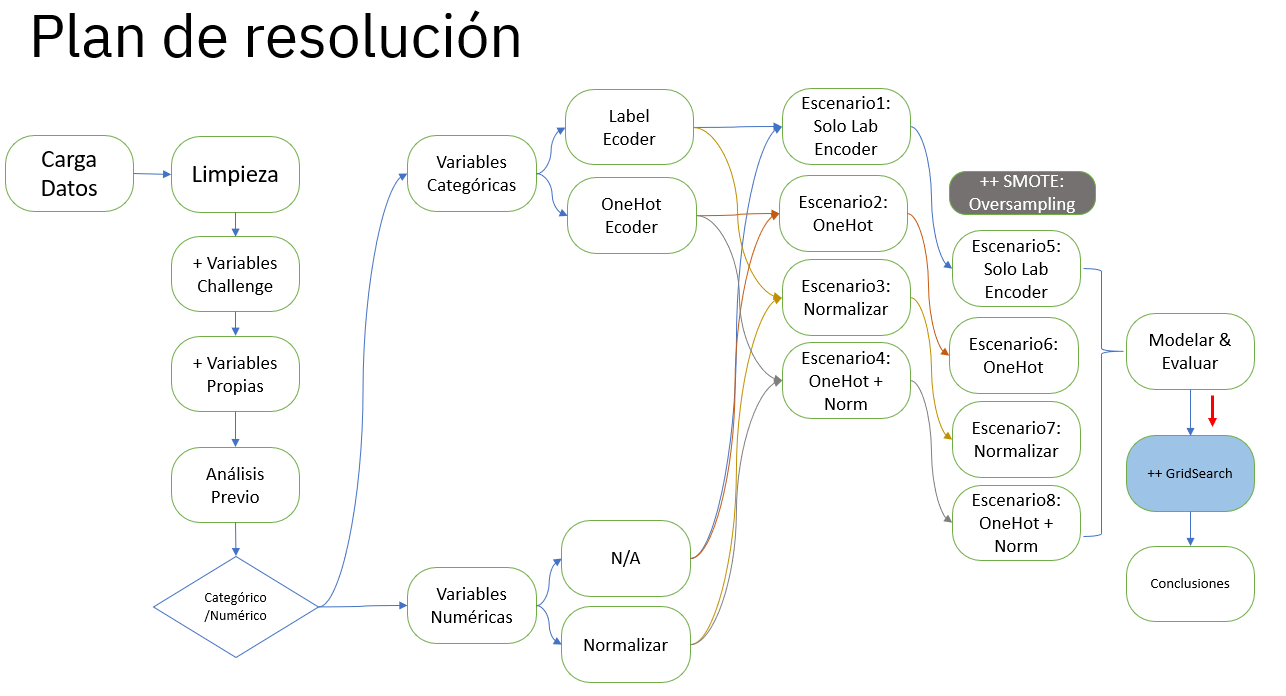

## Escenario 9: Escenario 7 con GridSearch

In [ ]:
params = {
   "learning_rate": [0.001,0.008, 0.016],
   "max_depth": [6,8,10],
   "num_leaves": [2**6, 2**8, 2**10],
}

In [ ]:

lgbm_simple = lgbm.LGBMClassifier(random_satate = 42,scale_pos_weight = 1, first_metric_only = True, n_estimators = 5000)

clf_gridsearch = GridSearchCV(estimator = lgbm_simple, param_grid = params, n_jobs = -1, cv=5)


In [ ]:
clf_gridsearch.fit(X_train_norsm, y_train_norsm, eval_set= [(X_test_norsm, y_test_norsm)], eval_metric = 'auc', early_stopping_rounds=100)

In [ ]:
clf_gridsearch.cv_results_

In [ ]:
clf_gridsearch.best_params_

# Conclusiones

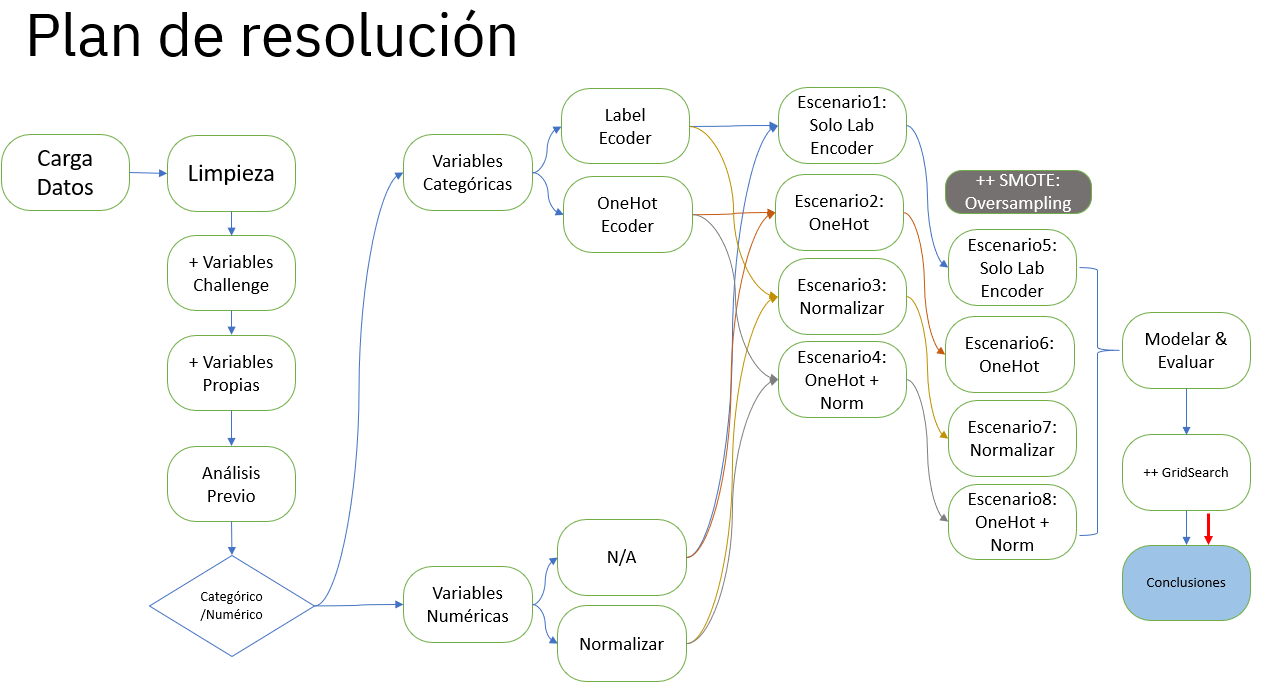

## Respuestas desafíos
**1** ¿Cómo se distribuyen los datos? ¿Qué te llama la atención? <br>
Encuentro que en las variables del dataset inicial  hay una importante correlación con la dif_min:
<br>
1 MES 0.072 <br>
2 TIPOVUELO 0.071 <br>
3 Vlo-I / Vlo-O 0.62 <br>
4 SIGLADES 0.053 <br>

También hay gran diferencia entre el promedio y la mediana de la diferencia en minutos de los atrasos. Por lo que se puede concluir que hay fuertes outliers en los atrasos <br>

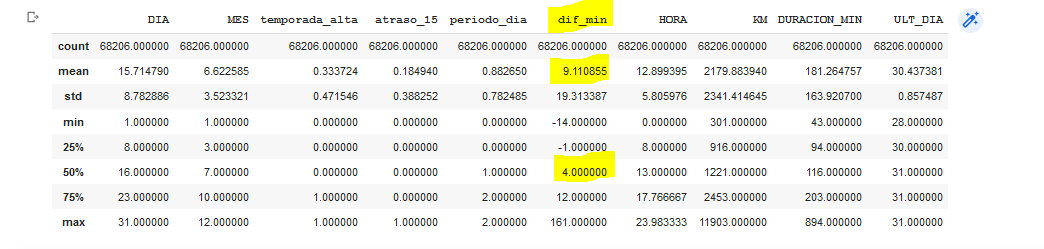

Además que es un problema bastante desbalanceado <br>

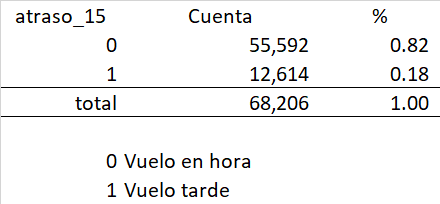

<br><br>

**2** Genera Columnas adicionales <br>
      **Rpta** Generé las columnas adicionales, podrán encontrar el archivo en synthetic_features.csv en el repositorio <br><br>

**3**  ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?  <br>

tasa de atraso por destino <br>
Para calcular los destinos con mayor retraso y que no nos veamos sesgados por la frequencia de los vuelos se saco el % de los vuelos con tardanza respecto al total por cada destino. Siempre y cuando hayan más de 20 vuelos a ese destino para que sea significativo. Se muestran en el cuadro destinos con más de 30% de sus vuelos con tardanza
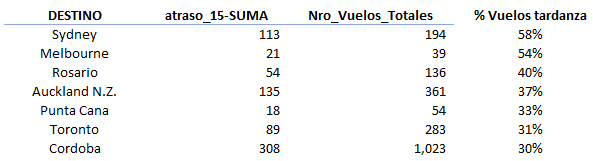

<br>

**1 Tasa de atraso por aerolinea ** <br>
Siguiendo la lógica anterior anterior, muestran las aerolíneas cuyas tardanzas representan más del 30% de sus vuelos 

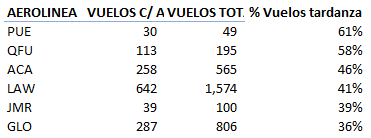

<br>

**3. tasa de atraso por mes dia y temporada** <br>
3.1 Mes <br>
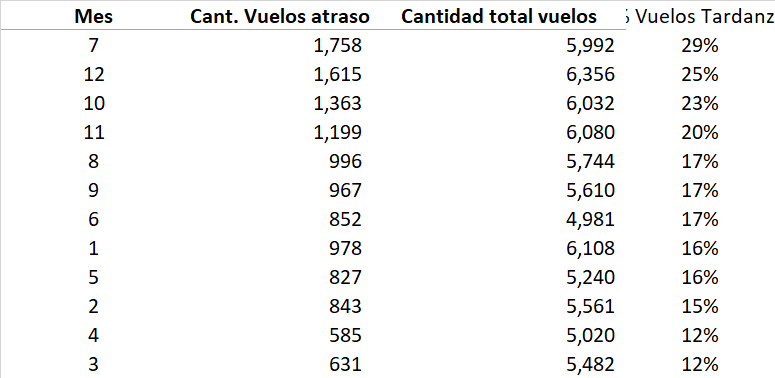
<br>

3.2 Dia

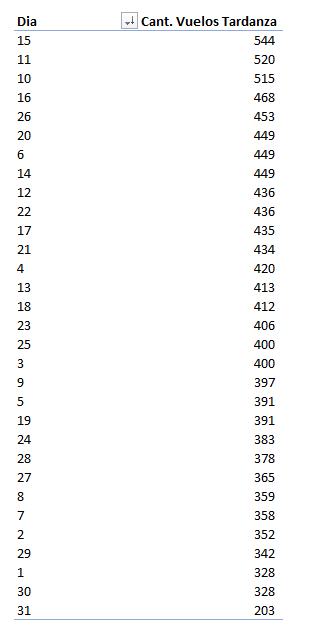

<br>

3.3 Temporada <br>

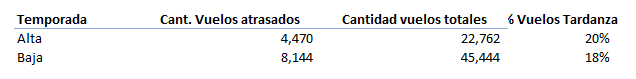
<br>

**4. tasa de atraso por tipo de vuelo** <br>
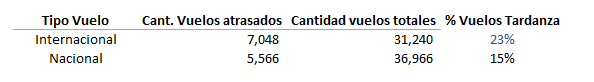
<br>

**4** Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas. <br>
<br><br>
Generé las variables externas:<br>
1 Evento: Feriados de chile<br>
2 HORA: Hora de partida<br>
3 Emp-Vlo: Concatenación de Emp y Vlo<br>
4 Duración_hrs: Duración del vuelo<br>
5 KM: Distancia en KM al destino<br>
6 ULT_DIA: Último día del mes<br>



**5** Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?  <br><br>

  **Rpta** Usé las métrica F1 y AUC, pues ambas son bastánte **ácidas** para medir la discriminación de un modelo y tuve en test 0.88 y 0.89 respectivamente, que para estos indicadores en especial son valores que reflejan lo bien que discrimina las demoras. Además de ser **estable**, pues al predecir TRAIN y compararlo con TEST tengo una diferencia de 0.02 en ambos indicadores, demostrando que no es un modelo con overfitting.<br>

Se corrieron 8 escenarios, siendo el escenario 7 (Normalización de variables numéricas y oversampling con SMOTE) la que obtuvo los mayores indicadores de AUC y F1 y además que tengan enor overfitting (diferencia TRAIN - TEST < 0.03)

<br>
Detalle: <br>
Escenario7 Norm+SMOTE f1_TRAIN score: **0.9090** <br>
Escenario7 Norm+SMOTE f1_TEST score: **0.8812** <br>
DELTA EN F1: 0.027 -> estable <br>
<br>
Escenario7 Norm+SMOTE auc_TRAIN score: **0.9153** <br>
Escenario7 Norm+SMOTE auc_TEST score: **0.8900** <br>
DELTA EN AUC: 0.0253 <br>

Elegí LightGBM porque por experiencia es un algoritmo que tiene buena performance y en clasificación logra discriminar correctamente los datos. Además de ser bastante rápido. Varios de los bancos peruanos usan este algoritmo por su fiabilidad. 

Adjunto un gráfico de las vbariables que más afectaron en la predicción: <br>
En donde las variables resaltadas son las que yo agregué y las marcadas en azul las 4 más importantes.
<br>

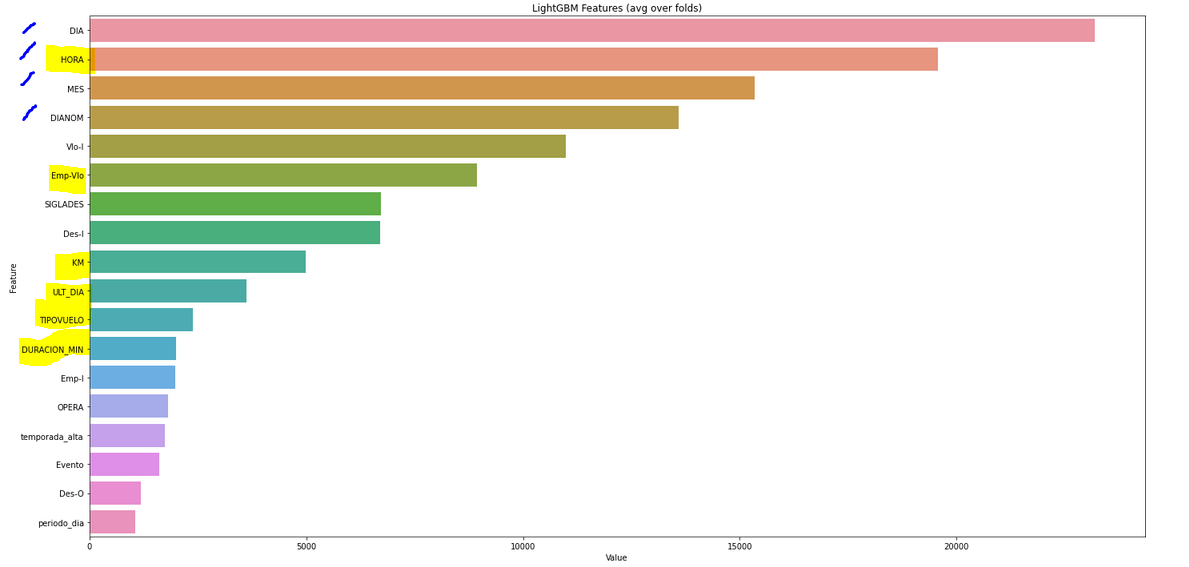

## Recomedaciones y siguientes pasos:
**1** Hacer un modelo de regresión teniendo como target a **dif_min** para poder predecir los minutos de retraso de vuelos nuevos y sobre eso tomar medidas para reducir los costos de sobretiempos.

**2** Para presentar la idea al negocio se recomienda calcular el costo del retraso  tenerla como un indicador de control. 
Para ello multiplicar las horas retraso del siguiente trimestre por el costo (USD/HrRetraso) para estima el impacato que tiene no evitar estos retrasos.

costo_retraso = 

# 7. Modeling with Deep Learning

In [ ]:
import tensorflow as tf # NN, LOSS FUNCTION, METRICS, ETC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
es_cl = EarlyStopping(monitor = 'loss', mode='max', patience = 30, verbose = 1)
mc_cb = ModelCheckpoint(filepath = "bestmodel1.hdf5", monitor= 'loss', save_best_only= True)
#.BinaryAccuracy()

In [ ]:
tf.random.set_seed(40) #SEMILA ALEATORIA PARA QUE LA SUERTE NO SEA DETERMINANTE NUNCA


model = Sequential()
model.add(Dense(512,activation='relu', input_shape = (693,)))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())



In [ ]:
X_train_all.shape[1]

693

In [ ]:
history = model.fit(X_train_all, y_train_oh, validation_data = (X_test_all,y_test_oh), epochs = 100, callbacks = [es_cl, mc_cb], batch_size=128)


Epoch 1/100
453/453 [==============================] - 9s 20ms/step - loss: 0.3747 - binary_accuracy: 0.8407 - val_loss: 0.4717 - val_binary_accuracy: 0.8117
Epoch 2/100
453/453 [==============================] - 7s 14ms/step - loss: 0.3748 - binary_accuracy: 0.8398 - val_loss: 0.4630 - val_binary_accuracy: 0.8144
Epoch 3/100
453/453 [==============================] - 6s 14ms/step - loss: 0.3728 - binary_accuracy: 0.8405 - val_loss: 0.4674 - val_binary_accuracy: 0.8117
Epoch 4/100
453/453 [==============================] - 8s 17ms/step - loss: 0.3732 - binary_accuracy: 0.8404 - val_loss: 0.4648 - val_binary_accuracy: 0.8168
Epoch 5/100
453/453 [==============================] - 8s 17ms/step - loss: 0.3719 - binary_accuracy: 0.8397 - val_loss: 0.4752 - val_binary_accuracy: 0.8114
Epoch 6/100
 58/453 [==>...........................] - ETA: 4s - loss: 0.3740 - binary_accuracy: 0.8429

KeyboardInterrupt: ignored